# Coursera Capstone Project - The Battle of Neighborhoods 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Explore & Analyze Top Cities in Philippines</a>

3. <a href="#item3">Explore Neighborhoods of Selected Top City</a>

4. <a href="#item4">Analyze Each Neighborhood</a>

5. <a href="#item5">Cluster Neighborhoods</a>

6. <a href="#item6">Examine Clusters</a>    
</font>
</div>

<a id='item1'></a>


## 1. Download and Explore Dataset 

#### Import all required libraries

In [5]:
import requests
import numpy as np

import pandas as pd # library for data analsysis
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


!conda install -c conda-forge folium=0.5.0 --yes
import folium

# package to scrape and extract data from website
from bs4 import BeautifulSoup
import lxml

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

mpl.style.use('ggplot') # optional: for ggplot-like style

import seaborn as sns

#!conda install -c conda-forge geopy --yes # uncomment if not yet installed
from geopy.geocoders import Nominatim

# import k-means for clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge wordcloud --yes
from wordcloud import WordCloud, STOPWORDS 

print ('Matplotlib version: ', mpl.__version__) # # check for latest version of Matplotlib >= 2.0.0
print('All Libraries imported!')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  50.86 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  40.24 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  42.84 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  49.82 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py35_0 conda-forge

wordcloud-1.4. 100% |################################| Time: 0:00:00  49.20 MB/s
Matpl

### Prepare the data

In [6]:
# Get list of cities of Philippines from Wikipedia
source = requests.get('https://en.wikipedia.org/wiki/List_of_cities_in_the_Philippines').text
soup = BeautifulSoup(source, 'lxml')

table = soup.find('table', class_='wikitable sortable')
table_rows = table.find_all('tr')

data = []

for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    data.append(row)

df = pd.DataFrame(data, columns=["City", "Population", "Area", "Density", "Province", "Region", "Class", "Charter", "Approval", "Ratification"])
df.head()

,City,Population,Area,Density,Province,Region,Class,Charter,Approval,Ratification
0,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None
3,Alaminos\n,"89,708\n",7008164260000000000♠164.26 km2(63.42 sq mi)\n,"6996549999999999999♠550/km2(1,400/sq mi)\n",Pangasinan\n,I\n,CC\n,RA 09025 [7]\n,2001 Mar 5 [7]\n,2001 Mar 28 [8]\n
4,Angeles\n,"411,634 [vi]\n",7007602700000000000♠60.27 km2(23.27 sq mi)\n,"6997620000000000000♠6,200/km2(16,000/sq mi)\n",Pampanga\n,III\n,HUC\n,RA 03700 [9]\n,1963 Jun 22 [9]\n,1964 Jan 1\n


In [7]:
df.shape

(150, 10)

### Clean the data

In [8]:
#Drop unnecessary columns and characters
df=df.drop(['Charter', 'Approval', "Ratification", "Province"], axis=1)
df=df.replace('\n','', regex=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,City,Population,Area,Density,Region,Class
0,Alaminos,"89,708",7008164260000000000♠164.26 km2(63.42 sq mi),"6996549999999999999♠550/km2(1,400/sq mi)",I,CC
1,Angeles,"411,634 [vi]",7007602700000000000♠60.27 km2(23.27 sq mi),"6997620000000000000♠6,200/km2(16,000/sq mi)",III,HUC
2,Antipolo,"776,386",7008306100000000000♠306.10 km2(118.19 sq mi),"6997250000000000000♠2,500/km2(6,500/sq mi)",IV-A,CC
3,Bacolod,"561,875",7008162670000000000♠162.67 km2(62.81 sq mi),"6997349999999999999♠3,500/km2(9,100/sq mi)",VI,HUC
4,Bacoor,"600,609",7007461700000000000♠46.17 km2(17.83 sq mi),"6998130000000000000♠13,000/km2(34,000/sq mi)",IV-A,CC


In [9]:
# Remove region number under Population column
df['Population'] = df['Population'].str.replace(r'[^\d.]+', '')
df.head()

,City,Population,Area,Density,Region,Class
0,Alaminos,89708,7008164260000000000♠164.26 km2(63.42 sq mi),"6996549999999999999♠550/km2(1,400/sq mi)",I,CC
1,Angeles,411634,7007602700000000000♠60.27 km2(23.27 sq mi),"6997620000000000000♠6,200/km2(16,000/sq mi)",III,HUC
2,Antipolo,776386,7008306100000000000♠306.10 km2(118.19 sq mi),"6997250000000000000♠2,500/km2(6,500/sq mi)",IV-A,CC
3,Bacolod,561875,7008162670000000000♠162.67 km2(62.81 sq mi),"6997349999999999999♠3,500/km2(9,100/sq mi)",VI,HUC
4,Bacoor,600609,7007461700000000000♠46.17 km2(17.83 sq mi),"6998130000000000000♠13,000/km2(34,000/sq mi)",IV-A,CC


In [10]:
#Clean Density column
df1=df
df1['Density'] = df1['Density'].str.split('(').str[1]
df1['Density'] = df1['Density'].str.split('/').str[0]
df1['Density'] = df1['Density'].str.replace(',', '')
df1['Density'] = df1['Density'].str.strip()
df1.reset_index(drop=True, inplace=True)
df1.head()

,City,Population,Area,Density,Region,Class
0,Alaminos,89708,7008164260000000000♠164.26 km2(63.42 sq mi),1400,I,CC
1,Angeles,411634,7007602700000000000♠60.27 km2(23.27 sq mi),16000,III,HUC
2,Antipolo,776386,7008306100000000000♠306.10 km2(118.19 sq mi),6500,IV-A,CC
3,Bacolod,561875,7008162670000000000♠162.67 km2(62.81 sq mi),9100,VI,HUC
4,Bacoor,600609,7007461700000000000♠46.17 km2(17.83 sq mi),34000,IV-A,CC


In [11]:
#Clean Area column
df1['Area'] = df1['Area'].str.split('(').str[1]
df1.reset_index(drop=True, inplace=True)
df1['Area'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
df1['Area'] = df1['Area'].str.strip()
df1["Area"]=df1["Area"].astype(float)
df1['Area'] = df1['Area'].div(100, axis='index')
df1.head()

,City,Population,Area,Density,Region,Class
0,Alaminos,89708,63.42,1400,I,CC
1,Angeles,411634,23.27,16000,III,HUC
2,Antipolo,776386,118.19,6500,IV-A,CC
3,Bacolod,561875,62.81,9100,VI,HUC
4,Bacoor,600609,17.83,34000,IV-A,CC


In [12]:
df1.dtypes

City           object
Population     object
Area          float64
Density        object
Region         object
Class          object
dtype: object

In [13]:
#Convert Population and Density to int
df1["Population"]=df1["Population"].astype(int)
df1["Density"]=df1["Density"].astype(int) #float
df1.dtypes

City           object
Population      int64
Area          float64
Density         int64
Region         object
Class          object
dtype: object

In [14]:
#Rename columns
df1.rename(columns={'Area': 'Area(sq mi)', 'Density': 'Density(/sq mi)'}, inplace=True)
df1.head()

,City,Population,Area(sq mi),Density(/sq mi),Region,Class
0,Alaminos,89708,63.42,1400,I,CC
1,Angeles,411634,23.27,16000,III,HUC
2,Antipolo,776386,118.19,6500,IV-A,CC
3,Bacolod,561875,62.81,9100,VI,HUC
4,Bacoor,600609,17.83,34000,IV-A,CC


In [15]:
#Select Highly Urbanized Cities (HUC) only
huc_df = df1[df1['Class'] == 'HUC'].reset_index(drop=True)
huc_df

,City,Population,Area(sq mi),Density(/sq mi),Region,Class
0,Angeles,411634,23.27,16000,III,HUC
1,Bacolod,561875,62.81,9100,VI,HUC
2,Baguio,345366,22.20,16000,CAR,HUC
3,Butuan,337063,315.30,1100,XIII,HUC
4,Cagayan de Oro,675950,159.38,4100,X,HUC
5,Caloocan,1583978,20.59,78000,NCR,HUC
6,Cebu City,922611,121.62,7500,VII,HUC
7,Davao City,1632991,943.48,1700,XI,HUC
8,General Santos,594446,190.29,3100,XII,HUC
9,Iligan,342618,314.04,1100,X,HUC


In [16]:
huc_df.shape

(33, 6)

In [17]:
# Get geo data of cities, read csv into dataframe
url="https://drive.google.com/uc?export=download&id=14u3quuA5jXaaQoHWylh4OxZvChiHVRHE"
geo_coords = pd.read_csv(url, encoding='latin-1', sep = ',') #, sep = ',', skiprows=2   header=[0] , header=None
geo_coords

,City,Latitude,Longitude
0,Angeles,15.152148,120.590263
1,Bacolod,10.667960,122.949699
2,Baguio,16.413019,120.590759
3,Butuan,8.947560,125.541054
4,Cagayan de Oro,8.485870,124.647942
5,Caloocan,14.651330,120.972481
6,Cebu City,10.311210,123.892342
7,Davao City,7.065730,125.610771
8,General Santos,6.118870,125.174149
9,Iligan,8.232850,124.241463


In [18]:
#pd.merge(df_new, df_n, on='subject_id')
huc_df2 = pd.merge(huc_df, geo_coords, on='City')
huc_df2

,City,Population,Area(sq mi),Density(/sq mi),Region,Class,Latitude,Longitude
0,Angeles,411634,23.27,16000,III,HUC,15.152148,120.590263
1,Bacolod,561875,62.81,9100,VI,HUC,10.667960,122.949699
2,Baguio,345366,22.20,16000,CAR,HUC,16.413019,120.590759
3,Butuan,337063,315.30,1100,XIII,HUC,8.947560,125.541054
4,Cagayan de Oro,675950,159.38,4100,X,HUC,8.485870,124.647942
5,Caloocan,1583978,20.59,78000,NCR,HUC,14.651330,120.972481
6,Cebu City,922611,121.62,7500,VII,HUC,10.311210,123.892342
7,Davao City,1632991,943.48,1700,XI,HUC,7.065730,125.610771
8,General Santos,594446,190.29,3100,XII,HUC,6.118870,125.174149
9,Iligan,342618,314.04,1100,X,HUC,8.232850,124.241463


<a id='item2'></a>

## 2. Explore & Analyze Top Cities in Philippines

In [19]:
# create a plain Philippine map
ph_map = folium.Map(location=[14.599512, 120.984222], zoom_start=5) #tiles='Mapbox Bright'

ph_map

In [20]:
# Map with markers - Bubble map with Folium

huc_df2["Density(/sq mi)"]=huc_df2["Density(/sq mi)"].astype(float)

for i in range(0,len(huc_df2)):
   folium.Circle(
      location=[huc_df2.iloc[i]['Latitude'], huc_df2.iloc[i]['Longitude']],
      popup=huc_df2.iloc[i]['City'],
      radius=huc_df2.iloc[i]['Density(/sq mi)'], #*10000
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(ph_map)

ph_map

In [21]:
!wget --quiet https://raw.githubusercontent.com/macoymejia/geojsonph/master/MuniCities/MuniCities.minimal.json -O ph_geojson.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [22]:
ph_geo = r'ph_geojson.json' # geojson file

# generate choropleth map using the Density (per sq mi) of HUC in the Philippines
ph_map.choropleth(
    geo_data=ph_geo,
    data=huc_df2,
    columns=['City', 'Density(/sq mi)'],
    key_on='feature.properties.NAME_2',
    fill_color='YlOrRd', #YlOrRd
    fill_opacity=0.4, 
    line_opacity=0.2,
    legend_name='Population of Highly Urbanized Cities in the Philippines '
)

# display map
ph_map

In [23]:
[print (type(x)) for x in huc_df2.columns.values] #to check type of column headers

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


[None, None, None, None, None, None, None, None]

### Select National Capital Region (NCR) Cities only

In [24]:
#Focus and select cities from NCR Region only as per above findings 

ncr_df = huc_df2[huc_df2['Region'] == 'NCR'].reset_index(drop=True)
ncr_df

,City,Population,Area(sq mi),Density(/sq mi),Region,Class,Latitude,Longitude
0,Caloocan,1583978,20.59,78000.0,NCR,HUC,14.65133,120.972481
1,Las Piñas,588894,12.62,47000.0,NCR,HUC,14.44909,120.982552
2,Makati,582602,8.33,70000.0,NCR,HUC,14.56872,121.028221
3,Malabon,365525,6.07,60000.0,NCR,HUC,14.65728,120.951080
4,Mandaluyong,386276,8.21,47000.0,NCR,HUC,14.57836,121.032806
5,Manila,1780148,16.56,110000.0,NCR,HUC,14.58865,120.984528
6,Marikina,450741,8.31,54000.0,NCR,HUC,14.63297,121.098602
7,Muntinlupa,504509,15.35,34000.0,NCR,HUC,14.39506,121.044891
8,Navotas,249463,4.16,73000.0,NCR,HUC,14.65818,120.947540
9,Parañaque,665822,18.41,36000.0,NCR,HUC,14.47082,121.021873


In [25]:
ncr_df.set_index('City', inplace=True) # Set City as index

# Sort dataframe on 'Density' column 
ncr_df.sort_values(by='Density(/sq mi)', ascending=True, inplace=True)
ncr_df

ncr_df["Density(/sq mi)"]=ncr_df["Density(/sq mi)"].astype(int)

# Get top NCR cities
ncr_top = ncr_df['Density(/sq mi)'].tail(13)
ncr_top

City
Taguig          39000
Pasig           41000
Quezon City     44000
Las Piñas       47000
Mandaluyong     47000
Marikina        54000
San Juan        54000
Malabon         60000
Makati          70000
Navotas         73000
Caloocan        78000
Pasay           78000
Manila         110000
Name: Density(/sq mi), dtype: int64

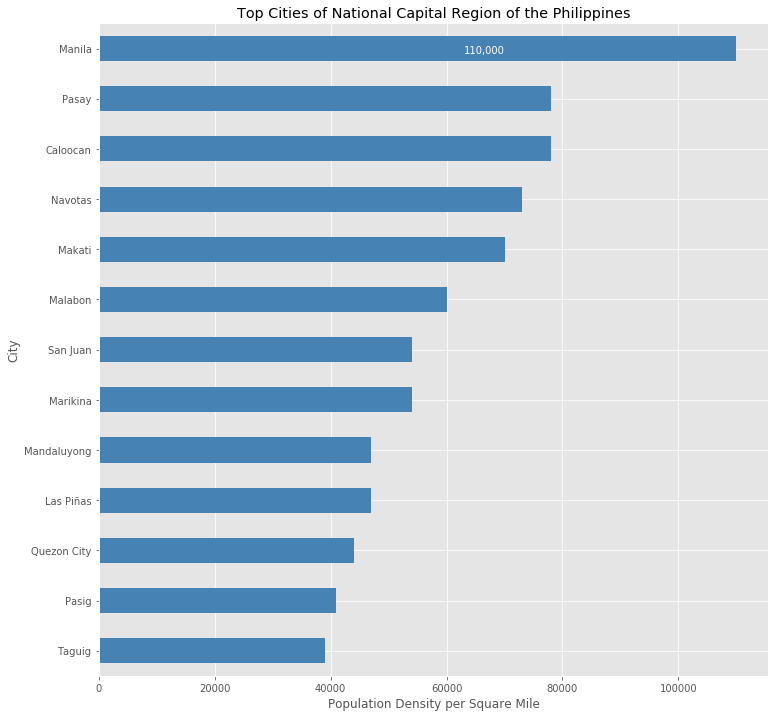

In [26]:
# generate plot
ncr_top.plot(kind='barh', figsize=(12, 12), color='steelblue')
plt.xlabel('Population Density per Square Mile')
plt.title('Top Cities of National Capital Region of the Philippines')

# annotate value labels to each city
for index, value in enumerate(ncr_top): 
    label = format(int(value), ',') # format int with commas = 
    
# place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
plt.annotate(label, xy=(value - 47000, index - 0.10), color='white')

plt.show()

#huc_df2["Density(/sq mi)"]=huc_df2["Density(/sq mi)"].astype(int)

###  NCR: Projected Population by Selected Age Group, and by Five-Calendar Years, Philippines: 2010-2045

In [27]:
# Read csv into dataframe
url2="https://drive.google.com/uc?export=download&id=14T-Bqx3aNbKoWsUgqLOUGL0_bYj62D4G"
ncr_pop = pd.read_csv(url2, encoding='latin-1', sep = ',') #, sep = ',', skiprows=2   header=[0] , header=None,  encoding='latin-1'

ncr_pop.set_index('Year', inplace=True) # Set City as index
#ncr_pop = ncr_pop.sort_values(['Age:0-14'], ascending=[False])
ncr_pop

,Age:0-14,Age:15-64,Age:65&over,total
Year,,,,
2015,3550200,8556200,545300,12651700
2020,3577900,8974200,728800,13280900
2025,3518700,9262400,974100,13755200
2030,3201000,9666800,1245600,14113400
2035,2918600,9901900,1545100,14365600
2040,2695200,9959400,1853300,14507900
2045,2475400,9817900,2215000,14508300


In [28]:
ncr_pop=ncr_pop.drop(['total'], axis=1)
ncr_pop

,Age:0-14,Age:15-64,Age:65&over
Year,,,
2015,3550200,8556200,545300
2020,3577900,8974200,728800
2025,3518700,9262400,974100
2030,3201000,9666800,1245600
2035,2918600,9901900,1545100
2040,2695200,9959400,1853300
2045,2475400,9817900,2215000


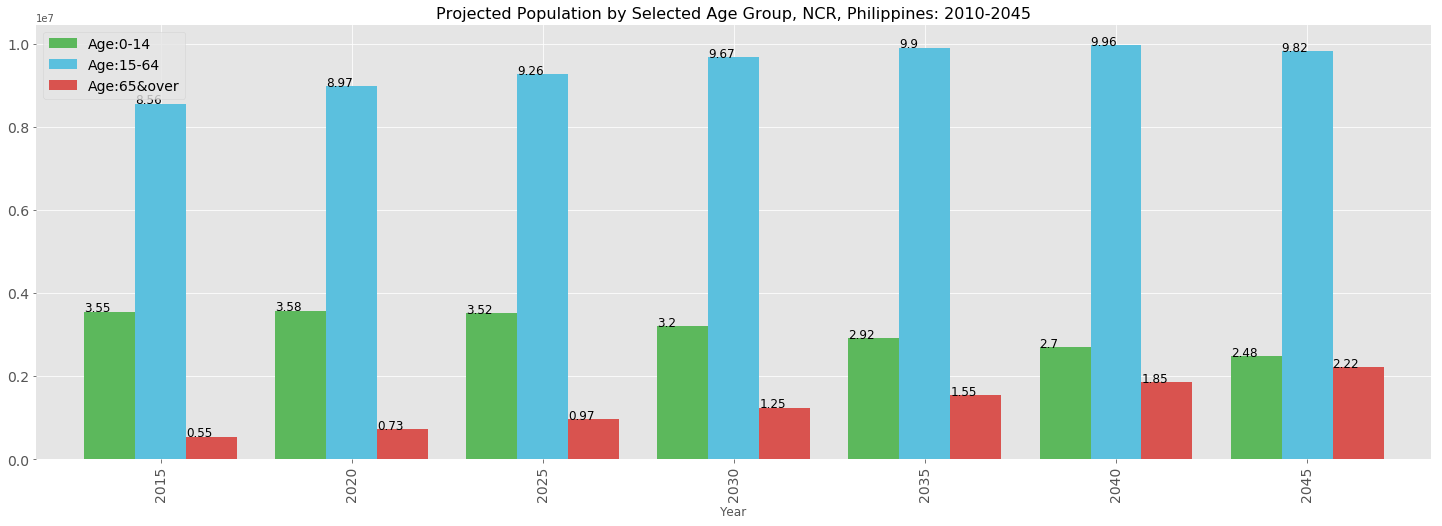

In [29]:
colors = ['#5cb85c','#5bc0de','#d9534f','#d9984f'] 

ax = ncr_pop.plot(kind='bar', figsize=(25,8), width=0.8, color=colors, edgecolor=None, fontsize=14)

ax.set_title("Projected Population by Selected Age Group, NCR, Philippines: 2010-2045", fontsize=16) 
ax.legend(labels=ncr_pop, fontsize=14)
sns.set_style(None)

#set individual bar lables using above list
for i in ax.patches:
    value = round((i.get_height()/1000000), 2)
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.0, i.get_height()+50, str(value), fontsize=12)
    
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

### NCR: Consumer Price Index for All Income Households by Commodity Group and Geographic Area (CPI) 2012 to 2018

In [30]:
# Read csv into dataframe
url3="https://drive.google.com/uc?export=download&id=10j9ifEmznYZgGeZH59MkEgsYfFlFj2hK"
ncr_cpi = pd.read_csv(url3, encoding='latin-1', sep = ',') #, sep = ',', skiprows=2   header=[0] , header=None,  encoding='latin-1'

ncr_cpi    

,Year,Food And Non-Alcoholic Beverages,Alcoholic Beverages Tobacco And Other Vegetable-Based Tobacco Products,Clothing And Footwear,Housing Water Electricity Gas And Other Fuels,Furnishings Household Equipment And Routine Household Maintenance,Health,Transport,Communication,Recreation And Culture,Education,Restaurants And Miscellaneous Goods And Services
0,2012,100,100,100,100,100,100,100,100,100,100,100
1,2013,103,120,103,100,104,103,99,100,103,104,101
2,2014,108,128,108,102,108,107,100,100,106,109,102
3,2015,110,131,111,100,109,109,92,100,107,114,102
4,2016,113,136,113,98,110,111,90,101,108,118,103
5,2017,120,147,116,100,112,114,97,101,110,120,106
6,2018,128,179,119,106,116,118,105,101,112,123,110


In [31]:
ncr_cpi.set_index('Year', inplace=True) # Set Year as index
ncr_cpi.head(10)
# ncr_cpi = ncr_cpi[columns].transpose()
# ncr_cpi

,Food And Non-Alcoholic Beverages,Alcoholic Beverages Tobacco And Other Vegetable-Based Tobacco Products,Clothing And Footwear,Housing Water Electricity Gas And Other Fuels,Furnishings Household Equipment And Routine Household Maintenance,Health,Transport,Communication,Recreation And Culture,Education,Restaurants And Miscellaneous Goods And Services
Year,,,,,,,,,,,
2012,100,100,100,100,100,100,100,100,100,100,100
2013,103,120,103,100,104,103,99,100,103,104,101
2014,108,128,108,102,108,107,100,100,106,109,102
2015,110,131,111,100,109,109,92,100,107,114,102
2016,113,136,113,98,110,111,90,101,108,118,103
2017,120,147,116,100,112,114,97,101,110,120,106
2018,128,179,119,106,116,118,105,101,112,123,110


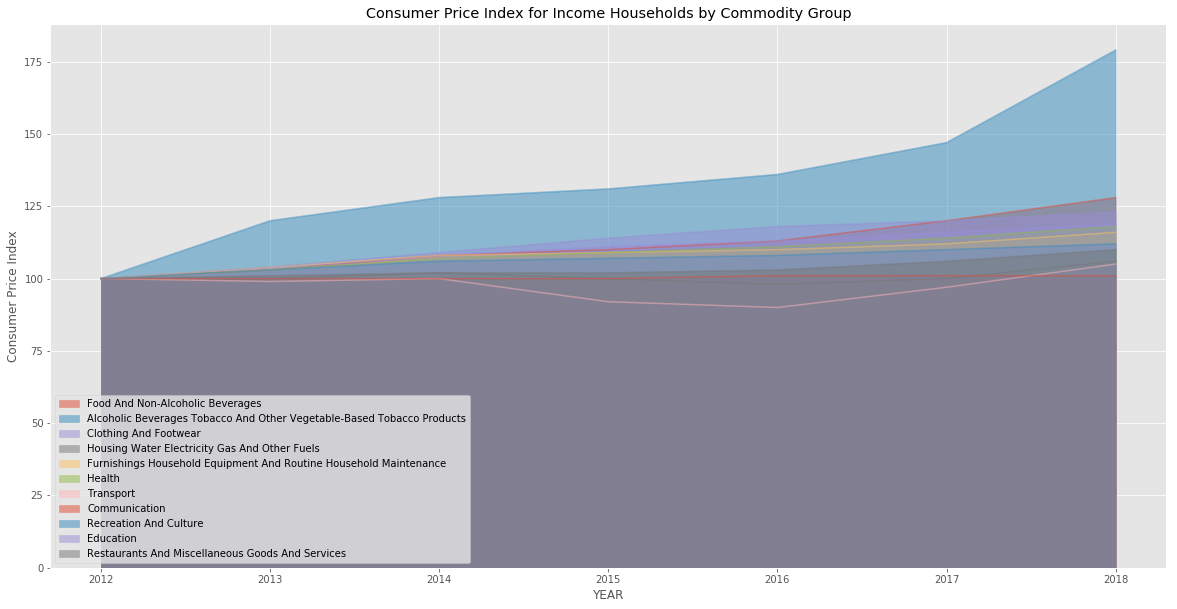

In [32]:
ncr_cpi.plot(kind='area', stacked=False,figsize=(20,10))

plt.title('Consumer Price Index for Income Households by Commodity Group')
plt.ylabel('Consumer Price Index')
plt.xlabel('YEAR')

plt.show()

<a id='item3'></a>

## 3. Explore Neighborhoods of Selected Top City (Makati)

In [33]:
# Get geo data of Makati neighborhoods 
url4="https://drive.google.com/uc?export=download&id=1O6dfrHEak5WhJuypa2m0uooDkr4ArQ0V"
makati_data = pd.read_csv(url4, encoding='latin-1', sep = ',') #, sep = ',', skiprows=2   header=[0] , header=None,  encoding='latin-1'

makati_data

,Borough,Neighborhood,Latitude,Longitude
0,Makati,Bangkal,14.54359,121.013153
1,Makati,Bel-Air,14.56145,121.023621
2,Makati,Carmona,14.57622,121.017250
3,Makati,Cembo,14.56535,121.050880
4,Makati,Comembo,14.54841,121.063942
5,Makati,Dasmariñas,14.53985,121.028221
6,Makati,East Rembo,14.55514,121.062523
7,Makati,Forbes Park,14.54600,121.036911
8,Makati,Guadalupe Nuevo,14.56103,121.046638
9,Makati,Guadalupe Viejo,14.56585,121.041656


Let's get the geographical coordinates of Makati.

In [34]:
address = 'Makati, Philippines'

geolocator = Nominatim(user_agent="ph_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Makati are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Makati are 14.55459465, 121.021407905201.


Let's visualize Makati neighborhoods in it.

In [35]:
# create map of Makati using latitude and longitude values
map_makati = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(makati_data['Latitude'], makati_data['Longitude'], makati_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_makati)  
    
map_makati

Define Foursquare Credentials and Version

In [36]:
# The code was removed by Watson Studio for sharing.

Let's create a function to get nearby venues to all the neighborhoods in Makati and get results

In [37]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a new dataframe called makati_venues for above function

In [38]:
makati_venues = getNearbyVenues(names=makati_data['Neighborhood'],
                                   latitudes=makati_data['Latitude'],
                                   longitudes=makati_data['Longitude']
                                  )

Bangkal
Bel-Air
Carmona
Cembo
Comembo
Dasmariñas
East Rembo
Forbes Park
Guadalupe Nuevo
Guadalupe Viejo
Kasilawan
La Paz
Magallanes
Olympia
Palanan
Pembo
Pinagkaisahan
Pio del Pilar
Pitogo
Poblacion
Rizal
San Antonio
San Isidro
San Lorenzo
Santa Cruz
Singkamas
South Cembo
Tejeros
Urdaneta
Valenzuela
West Rembo


Let's check the size of the resulting dataframe

In [39]:
print(makati_venues.shape)
makati_venues.head()

(910, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bangkal,14.54359,121.013153,100g Burger's,14.545715,121.013222,Burger Joint
1,Bangkal,14.54359,121.013153,Kaito Japanese Carinderia,14.543683,121.012782,Japanese Restaurant
2,Bangkal,14.54359,121.013153,FitFast Wellness and Fitness Center,14.547046,121.014352,Gym
3,Bangkal,14.54359,121.013153,Spare Strike,14.540995,121.011987,Tapas Restaurant
4,Bangkal,14.54359,121.013153,Nova Gallery,14.544795,121.016941,Art Gallery


Let's check how many venues were returned for each neighborhood

In [40]:
makati_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bangkal,32,32,32,32,32,32
Bel-Air,88,88,88,88,88,88
Carmona,23,23,23,23,23,23
Cembo,4,4,4,4,4,4
Comembo,14,14,14,14,14,14
Dasmariñas,5,5,5,5,5,5
East Rembo,4,4,4,4,4,4
Forbes Park,23,23,23,23,23,23
Guadalupe Nuevo,21,21,21,21,21,21


Let's find out how many unique categories can be curated from all the returned venues

In [41]:
print('There are {} uniques categories.'.format(len(makati_venues['Venue Category'].unique())))

There are 178 uniques categories.


<a id='item4'></a>

## 4. Analyze Each Neighborhood

In [42]:
# one hot encoding
makati_onehot = pd.get_dummies(makati_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
makati_onehot['Neighborhood'] = makati_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [makati_onehot.columns[-1]] + list(makati_onehot.columns[:-1])
makati_onehot = makati_onehot[fixed_columns]

makati_onehot.head()

,Yoga Studio,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,...,Theme Restaurant,Track,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
makati_onehot.shape

(910, 178)

#### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [44]:
makati_grouped = makati_onehot.groupby('Neighborhood').mean().reset_index()
makati_grouped

,Neighborhood,Yoga Studio,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Theme Restaurant,Track,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Bangkal,0.000000,0.031250,0.000000,0.00000,0.031250,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
1,Bel-Air,0.022727,0.000000,0.000000,0.00000,0.000000,0.011364,0.000000,0.011364,0.00,...,0.000000,0.011364,0.022727,0.011364,0.000000,0.000000,0.011364,0.011364,0.000000,0.00
2,Carmona,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.043478,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.00
3,Cembo,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
4,Comembo,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.071429,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
5,Dasmariñas,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
6,East Rembo,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
7,Forbes Park,0.000000,0.043478,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
8,Guadalupe Nuevo,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
9,Guadalupe Viejo,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [45]:
makati_grouped.shape

(31, 178)

#### Print each neighborhood along with the top 5 most common venues

In [46]:
num_top_venues = 5

for hood in makati_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = makati_grouped[makati_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bangkal----
                  venue  freq
0     Convenience Store  0.12
1          Cocktail Bar  0.09
2             Nightclub  0.06
3                   Bar  0.06
4  Fast Food Restaurant  0.06


----Bel-Air----
                 venue  freq
0          Coffee Shop  0.12
1                 Café  0.05
2          Pizza Place  0.03
3  Filipino Restaurant  0.03
4           Steakhouse  0.03


----Carmona----
                  venue  freq
0             Gastropub  0.09
1           Coffee Shop  0.09
2  Gym / Fitness Center  0.04
3     Convenience Store  0.04
4          Soccer Field  0.04


----Cembo----
               venue  freq
0  Convenience Store  0.25
1               Park  0.25
2           Pharmacy  0.25
3   Basketball Court  0.25
4       Perfume Shop  0.00


----Comembo----
                  venue  freq
0     Convenience Store  0.21
1                 Diner  0.14
2  Fast Food Restaurant  0.14
3            Soup Place  0.07
4          Dessert Shop  0.07


----Dasmariñas----
              ven

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = makati_grouped['Neighborhood']

for ind in np.arange(makati_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(makati_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangkal,Convenience Store,Cocktail Bar,Bar,Fast Food Restaurant,Nightclub,Burger Joint,Restaurant,Resort,Chinese Restaurant,Pub
1,Bel-Air,Coffee Shop,Café,Steakhouse,Pizza Place,Japanese Restaurant,Spa,Restaurant,Filipino Restaurant,Creperie,Mediterranean Restaurant
2,Carmona,Gastropub,Coffee Shop,Clothing Store,Convenience Store,Shopping Mall,Seafood Restaurant,Burger Joint,Café,Restaurant,Pastry Shop
3,Cembo,Park,Pharmacy,Basketball Court,Convenience Store,Cupcake Shop,Coworking Space,Farmers Market,Falafel Restaurant,Event Space,Empanada Restaurant
4,Comembo,Convenience Store,Diner,Fast Food Restaurant,Grocery Store,Soup Place,Food & Drink Shop,Dessert Shop,Breakfast Spot,Gym / Fitness Center,Asian Restaurant


<a id='item5'></a>

## 5. Cluster Neighborhoods

In [55]:
# set number of clusters
kclusters = 4

makati_grouped_clustering = makati_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(makati_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 0, 2, 3, 2, 1, 2, 2], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [56]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

makati_merged = makati_data

# merge makati_grouped with makati_data to add latitude/longitude for each neighborhood
makati_merged = makati_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

makati_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Makati,Bangkal,14.54359,121.013153,1,Convenience Store,Cocktail Bar,Bar,Fast Food Restaurant,Nightclub,Burger Joint,Restaurant,Resort,Chinese Restaurant,Pub
1,Makati,Bel-Air,14.56145,121.023621,1,Coffee Shop,Café,Steakhouse,Pizza Place,Japanese Restaurant,Spa,Restaurant,Filipino Restaurant,Creperie,Mediterranean Restaurant
2,Makati,Carmona,14.57622,121.017250,1,Gastropub,Coffee Shop,Clothing Store,Convenience Store,Shopping Mall,Seafood Restaurant,Burger Joint,Café,Restaurant,Pastry Shop
3,Makati,Cembo,14.56535,121.050880,0,Park,Pharmacy,Basketball Court,Convenience Store,Cupcake Shop,Coworking Space,Farmers Market,Falafel Restaurant,Event Space,Empanada Restaurant
4,Makati,Comembo,14.54841,121.063942,2,Convenience Store,Diner,Fast Food Restaurant,Grocery Store,Soup Place,Food & Drink Shop,Dessert Shop,Breakfast Spot,Gym / Fitness Center,Asian Restaurant


### Visualize the resulting clusters

In [57]:
import matplotlib.cm as cm
import matplotlib.colors as colors


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(makati_merged['Latitude'], makati_merged['Longitude'], makati_merged['Neighborhood'], makati_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item6'></a>

## 6. Examine Clusters

Cluster 1

In [58]:
makati_merged.loc[makati_merged['Cluster Labels'] == 0, makati_merged.columns[[1] + list(range(5, makati_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Cembo,Park,Pharmacy,Basketball Court,Convenience Store,Cupcake Shop,Coworking Space,Farmers Market,Falafel Restaurant,Event Space,Empanada Restaurant
15,Pembo,Convenience Store,Basketball Court,Cosmetics Shop,Creperie,Cupcake Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
20,Rizal,Basketball Court,Convenience Store,Breakfast Spot,Campground,Cupcake Shop,Coworking Space,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


Cluster 2

In [59]:
makati_merged.loc[makati_merged['Cluster Labels'] == 1, makati_merged.columns[[1] + list(range(5, makati_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bangkal,Convenience Store,Cocktail Bar,Bar,Fast Food Restaurant,Nightclub,Burger Joint,Restaurant,Resort,Chinese Restaurant,Pub
1,Bel-Air,Coffee Shop,Café,Steakhouse,Pizza Place,Japanese Restaurant,Spa,Restaurant,Filipino Restaurant,Creperie,Mediterranean Restaurant
2,Carmona,Gastropub,Coffee Shop,Clothing Store,Convenience Store,Shopping Mall,Seafood Restaurant,Burger Joint,Café,Restaurant,Pastry Shop
7,Forbes Park,Dessert Shop,Coffee Shop,Café,Lounge,Italian Restaurant,Japanese Restaurant,Breakfast Spot,Bar,Deli / Bodega,Field
11,La Paz,Convenience Store,Filipino Restaurant,Hotel,Bar,Cupcake Shop,Burger Joint,Café,Restaurant,Cosmetics Shop,Pizza Place
12,Magallanes,Spa,BBQ Joint,Food & Drink Shop,Mattress Store,Supermarket,Diner,Ice Cream Shop,Coffee Shop,Cupcake Shop,Electronics Store
13,Olympia,Convenience Store,Filipino Restaurant,Bar,Soup Place,Spa,Bike Shop,Beer Garden,Café,Shopping Mall,Tapas Restaurant
14,Palanan,Coffee Shop,Pizza Place,Pharmacy,Filipino Restaurant,Bakery,Garden,Bridal Shop,Snack Place,Fast Food Restaurant,Bookstore
16,Pinagkaisahan,Breakfast Spot,Sandwich Place,Convenience Store,Asian Restaurant,Grocery Store,Drugstore,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
17,Pio del Pilar,Japanese Restaurant,Convenience Store,Pizza Place,Tea Room,Restaurant,Music Venue,Spa,Fast Food Restaurant,Coffee Shop,Diner


Cluster 3

In [60]:
makati_merged.loc[makati_merged['Cluster Labels'] == 2, makati_merged.columns[[1] + list(range(5, makati_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Comembo,Convenience Store,Diner,Fast Food Restaurant,Grocery Store,Soup Place,Food & Drink Shop,Dessert Shop,Breakfast Spot,Gym / Fitness Center,Asian Restaurant
6,East Rembo,Fast Food Restaurant,River,Basketball Court,Breakfast Spot,Women's Store,Drugstore,Farmers Market,Falafel Restaurant,Event Space,Empanada Restaurant
8,Guadalupe Nuevo,Convenience Store,Fast Food Restaurant,Basketball Court,BBQ Joint,Smoke Shop,Farmers Market,Burger Joint,Electronics Store,Bakery,Breakfast Spot
9,Guadalupe Viejo,Fast Food Restaurant,Restaurant,Convenience Store,Italian Restaurant,Bakery,Market,Spanish Restaurant,Taco Place,Boutique,Bar
10,Kasilawan,Dim Sum Restaurant,Asian Restaurant,Convenience Store,Supermarket,Electronics Store,BBQ Joint,Grocery Store,Fast Food Restaurant,Department Store,Cupcake Shop
22,San Isidro,Fast Food Restaurant,Chinese Restaurant,Filipino Restaurant,Ramen Restaurant,Bar,Pizza Place,Pharmacy,Restaurant,Cupcake Shop,Convenience Store
30,West Rembo,Fast Food Restaurant,Convenience Store,Tapas Restaurant,Chinese Restaurant,Sandwich Place,Breakfast Spot,Soccer Stadium,Filipino Restaurant,Fried Chicken Joint,Coffee Shop


Cluster 4

In [61]:
makati_merged.loc[makati_merged['Cluster Labels'] == 3, makati_merged.columns[[1] + list(range(5, makati_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Dasmariñas,Soccer Field,Baseball Field,Plaza,Gym,Basketball Court,Farmers Market,Falafel Restaurant,Event Space,Empanada Restaurant,Electronics Store


### Creating word map on venue categories for each cluster

Following are the most common Venue Categories in Cluster 0 of Makati


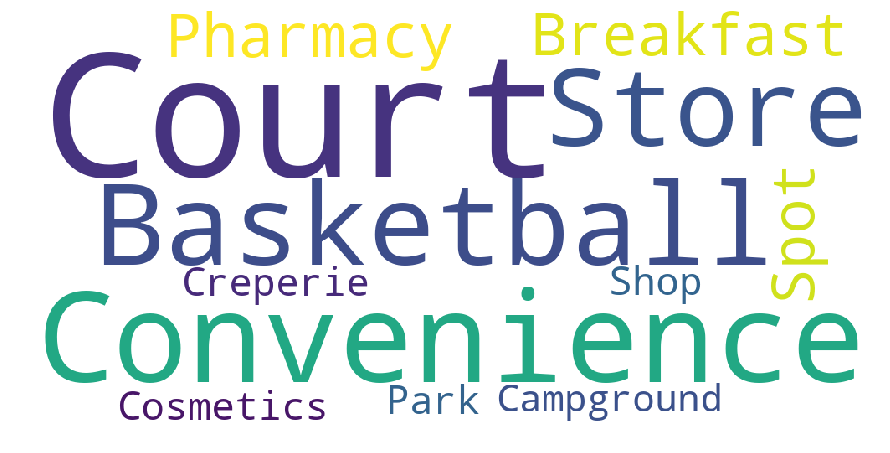

Following are the most common Venue Categories in Cluster 1 of Makati


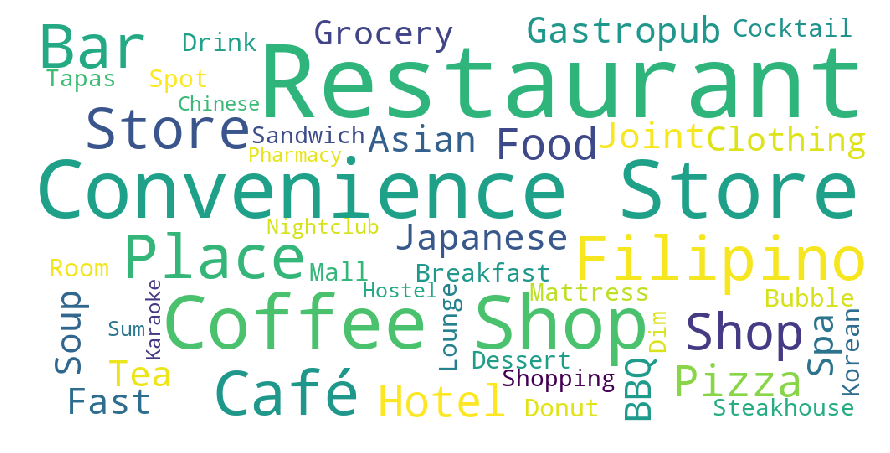

Following are the most common Venue Categories in Cluster 2 of Makati


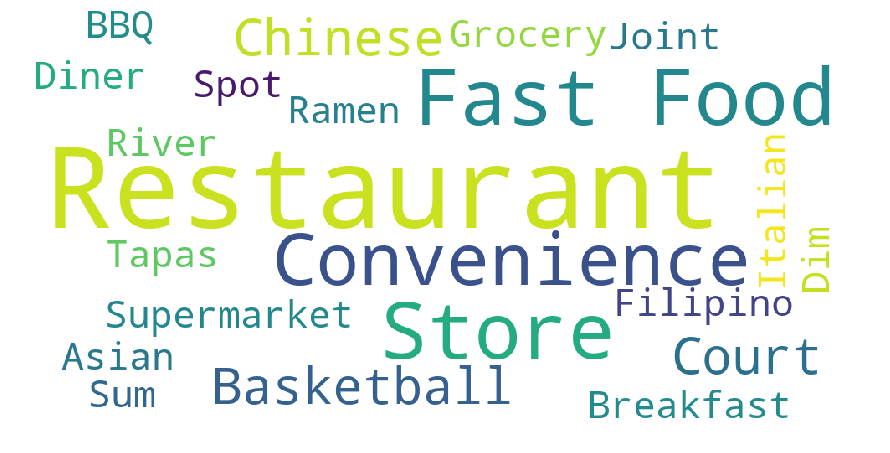

Following are the most common Venue Categories in Cluster 3 of Makati


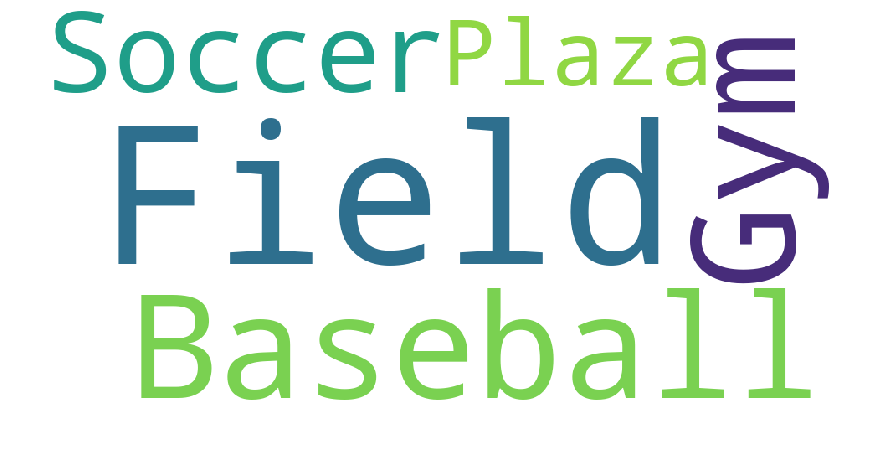

In [62]:
#Creating word map on venue categories for each cluster of Makati
for n in range(4):
    list_of_cat_makati = []
    for index, row in makati_merged.loc[makati_merged['Cluster Labels'] == n, makati_merged.columns[[0] + list(range(2, makati_merged.shape[1]))]].iterrows():
        list_of_cat_makati.append(row[4])
        list_of_cat_makati.append(row[5])
        list_of_cat_makati.append(row[6])
        list_of_cat_makati.append(row[7])
    unique_string = (' ').join(list_of_cat_makati)
    wordcloud = WordCloud(width = 1000, height = 500, background_color ='white').generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    print('Following are the most common Venue Categories in Cluster {} of Makati'.format (str(n)))
    plt.show()

### The end.  

### Please see Report (PDF) and Presentation (powerpoint) for discussion of results, observation, analysis and conlusion.  

### Thank you! 